In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, precision_score, recall_score, f1_score
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
tf.random.set_seed(42)
np.random.seed(42)

In [ ]:
data_dir = 'cell_images' 

In [ ]:
def load_image_paths_and_labels(data_dir):
    image_paths = []
    labels = []
    categories = ['Uninfected', 'Parasitized']
    label_map = {'Uninfected': 0, 'Parasitized': 1}
    
    for category in categories:
        folder_path = os.path.join(data_dir, category)
        for img_name in os.listdir(folder_path):
            img_path = os.path.join(folder_path, img_name)
            if img_name.endswith('.png'):
                image_paths.append(img_path)
                labels.append(label_map[category])
    
    return image_paths, labels

In [ ]:
# Datasetni yuklash
image_paths, labels = load_image_paths_and_labels(data_dir)
print(f'Jami tasvirlar soni: {len(image_paths)}')

Jami tasvirlar soni: 27552


In [ ]:
# Train/validation/test to‘plamlariga bo‘lish (60% train, 20% validation, 20% test)
train_paths, test_paths, train_labels, test_labels = train_test_split(
    image_paths, labels, test_size=0.2, random_state=42, stratify=labels
)
train_paths, val_paths, train_labels, val_labels = train_test_split(
    train_paths, train_labels, test_size=0.25, random_state=42, stratify=train_labels
)

print(f'Trening to‘plami hajmi: {len(train_paths)}')
print(f'Validatsiya to‘plami hajmi: {len(val_paths)}')
print(f'Test to‘plami hajmi: {len(test_paths)}')


Trening to‘plami hajmi: 16530
Validatsiya to‘plami hajmi: 5511
Test to‘plami hajmi: 5511


In [ ]:
# Batch generator funksiyasi (xotirani tejash uchun)
def batch_generator(image_paths, labels, batch_size=32, target_size=(128, 128), augment=False):
    num_samples = len(image_paths)
    indices = np.arange(num_samples)
    np.random.shuffle(indices)
    
    # Augmentatsiya uchun ImageDataGenerator
    if augment:
        datagen = ImageDataGenerator(
            rotation_range=20,
            zoom_range=0.2,
            horizontal_flip=True,
            vertical_flip=True
        )
    
    i = 0
    while True:
        batch_paths = image_paths[i:i + batch_size]
        batch_labels = labels[i:i + batch_size]
        
        batch_images = []
        for img_path in batch_paths:
            img = cv2.imread(img_path)
            img = cv2.resize(img, target_size)
            img = img / 255.0  # Normalizatsiya
            batch_images.append(img)
        
        batch_images = np.array(batch_images)
        batch_labels = np.array(batch_labels)
        
        # Augmentatsiya faqat trening uchun
        if augment:
            batch_images = np.array([datagen.random_transform(img) for img in batch_images])
        
        i += batch_size
        if i >= num_samples:
            i = 0
            np.random.shuffle(indices)
        
        yield batch_images, batch_labels

In [ ]:
# Generatorlarni yaratish
train_gen = batch_generator(train_paths, train_labels, batch_size=32, augment=True)
val_gen = batch_generator(val_paths, val_labels, batch_size=32, augment=False)
test_gen = batch_generator(test_paths, test_labels, batch_size=32, augment=False)

In [ ]:
# Trening va validatsiya qadamlari
steps_per_epoch = len(train_paths) // 32
validation_steps = len(val_paths) // 32
test_steps = len(test_paths) // 32

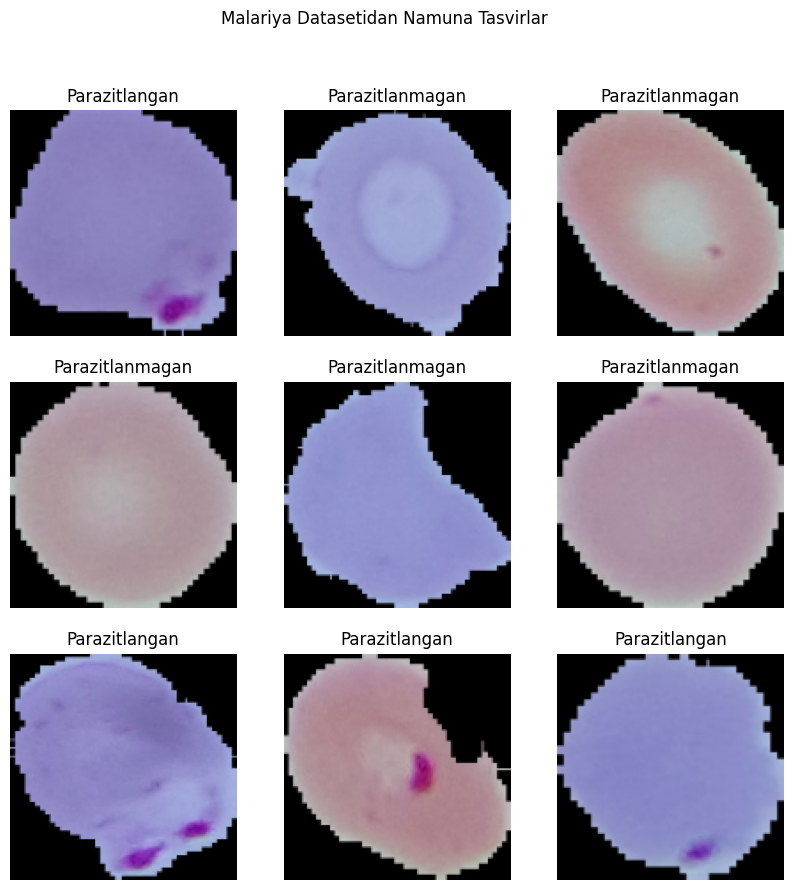

In [ ]:
# Namuna tasvirlarni ko‘rsatish
def plot_sample_images(image_paths, labels, num_samples=9):
    plt.figure(figsize=(10, 10))
    indices = np.random.choice(len(image_paths), num_samples, replace=False)
    
    for i, idx in enumerate(indices):
        img = cv2.imread(image_paths[idx])
        img = cv2.resize(img, (128, 128))
        img = img / 255.0
        plt.subplot(3, 3, i + 1)
        plt.imshow(img)
        plt.title('Parazitlanmagan' if labels[idx] == 0 else 'Parazitlangan')
        plt.axis('off')
    plt.suptitle('Malariya Datasetidan Namuna Tasvirlar')
    plt.show()

plot_sample_images(train_paths, train_labels)


In [ ]:
# Xususiyat xaritalarini ko‘rsatish funksiyasi
def plot_feature_maps(model, image):
    feature_map_model = models.Model(inputs=model.input, outputs=model.layers[0].output)
    image = image.reshape(1, 128, 128, 3)
    feature_maps = feature_map_model.predict(image)
    
    plt.figure(figsize=(15, 5))
    for i in range(8):
        plt.subplot(2, 4, i + 1)
        plt.imshow(feature_maps[0, :, :, i], cmap='viridis')
        plt.axis('off')
    plt.suptitle('Birinchi Konvolyutsion Qatlamdan Xususiyat Xaritalari')
    plt.show()

In [ ]:
def create_cnn_model():
    model = models.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3), padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        
        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2)),
        
        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2)),
        
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(1, activation='sigmoid')
    ])
    return model


In [ ]:
# Modelni yaratish va kompilyatsiya qilish
model = create_cnn_model()
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
            loss='binary_crossentropy',
            metrics=['accuracy'])

# Model xulosasi
model.summary()

c:\Users\zakhr\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 128, 128, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128, 128, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 32768)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     4,194,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,287,937 (16.36 MB)

 Trainable params: 4,287,873 (16.36 MB)

 Non-trainable params: 64 (256.00 B)

In [ ]:
# Modelni o‘qitish
history = model.fit(
    train_gen,
    steps_per_epoch=steps_per_epoch,
    validation_data=val_gen,
    validation_steps=validation_steps,
    epochs=20,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)
    ],
    verbose=1
)

Epoch 1/20
516/516 ━━━━━━━━━━━━━━━━━━━━ 411s 793ms/step - accuracy: 0.7739 - loss: 0.5459 - val_accuracy: 0.9493 - val_loss: 0.2048
Epoch 2/20
516/516 ━━━━━━━━━━━━━━━━━━━━ 433s 840ms/step - accuracy: 0.9453 - loss: 0.1807 - val_accuracy: 0.9513 - val_loss: 0.1554
Epoch 3/20
516/516 ━━━━━━━━━━━━━━━━━━━━ 376s 730ms/step - accuracy: 0.9476 - loss: 0.1647 - val_accuracy: 0.9542 - val_loss: 0.1352
Epoch 4/20
516/516 ━━━━━━━━━━━━━━━━━━━━ 375s 727ms/step - accuracy: 0.9533 - loss: 0.1500 - val_accuracy: 0.9571 - val_loss: 0.1324
Epoch 5/20
516/516 ━━━━━━━━━━━━━━━━━━━━ 375s 727ms/step - accuracy: 0.9540 - loss: 0.1433 - val_accuracy: 0.9586 - val_loss: 0.1410
Epoch 6/20
516/516 ━━━━━━━━━━━━━━━━━━━━ 369s 717ms/step - accuracy: 0.9548 - loss: 0.1389 - val_accuracy: 0.9595 - val_loss: 0.1281
Epoch 7/20
516/516 ━━━━━━━━━━━━━━━━━━━━ 380s 736ms/step - accuracy: 0.9542 - loss: 0.1375 - val_accuracy: 0.9606 - val_loss: 0.1289
Epoch 8/20
516/516 ━━━━━━━━━━━━━━━━━━━━ 353s 685ms/step - accuracy: 0.9571 -

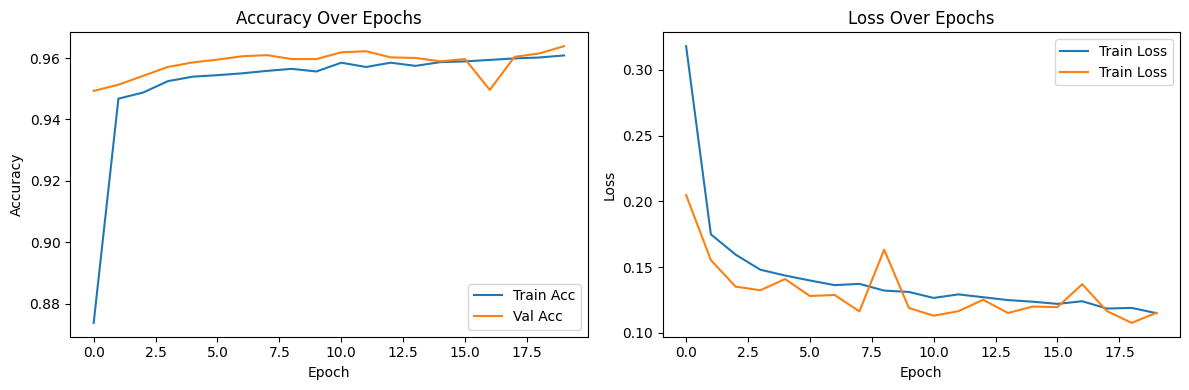

In [ ]:
# O‘qitish tarixini vizualizatsiya qilish
def plot_training_history(history):
    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Acc')
    plt.plot(history.history['val_accuracy'], label='Val Acc')
    plt.title('Accuracy Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Train Loss')
    plt.title('Loss Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

plot_training_history(history)

In [ ]:
# Test to‘plamida baholash
test_loss, test_accuracy = model.evaluate(test_gen, steps=test_steps)
print(f'Test aniqligi: {test_accuracy:.4f}, Test yo‘qotishi: {test_loss:.4f}')

172/172 ━━━━━━━━━━━━━━━━━━━━ 64s 367ms/step - accuracy: 0.9587 - loss: 0.1134
Test aniqligi: 0.9604, Test yo‘qotishi: 0.1102


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 482ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step

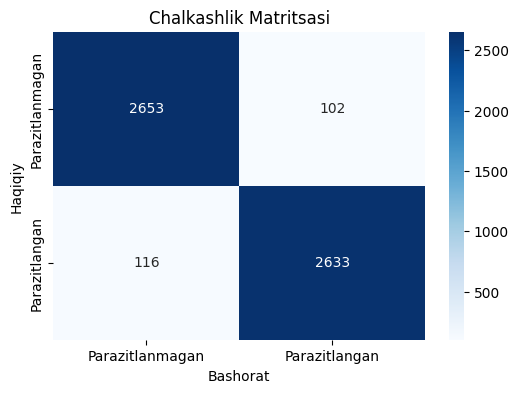

In [ ]:
# Confusion matrix va metrikalar
y_pred = []
y_true = []
for images, labels in test_gen:
    pred = model.predict(images)
    y_pred.extend((pred > 0.5).astype(int).flatten())
    y_true.extend(labels)
    if len(y_true) >= test_steps * 32:
        break

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Parazitlanmagan', 'Parazitlangan'],
            yticklabels=['Parazitlanmagan', 'Parazitlangan'])
plt.title('Chalkashlik Matritsasi')
plt.xlabel('Bashorat')
plt.ylabel('Haqiqiy')
plt.show()


In [ ]:
# Tasniflash hisoboti
print('Tasniflash Hisoboti:')
print(classification_report(y_true, y_pred, target_names=['Parazitlanmagan', 'Parazitlangan']))

Tasniflash Hisoboti:
                 precision    recall  f1-score   support

Parazitlanmagan       0.96      0.96      0.96      2755
  Parazitlangan       0.96      0.96      0.96      2749

       accuracy                           0.96      5504
      macro avg       0.96      0.96      0.96      5504
   weighted avg       0.96      0.96      0.96      5504



In [ ]:
# Qo‘shimcha metrikalar
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1-Score: {f1:.4f}')

Precision: 0.9627
Recall: 0.9578
F1-Score: 0.9602


In [ ]:
import joblib

joblib.dump(model, 'malaria_model.pkl')

['malaria_model.pkl']